<a href="https://colab.research.google.com/github/surajbhala/Slot-Identification-using-SNIPS-dataset/blob/master/Slot_Identification_on_SNIPS_data_using_Pytorch_and_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-pretrained-bert==0.4.0
!pip install seqeval==0.0.12

#importing packages for string processing,dataframe handling, array manipulations, etc
import string
import pandas as pd
import numpy as np
import json
from tqdm import tqdm, trange

#importing all the pytorch packages
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

#importing additonal packages to aid preprocessing of data
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

#importing packages to calculate the f1_score of our model
from seqeval.metrics import f1_score
import re

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7423 sha256=1e2a010e4a88e46fa18baa4dc86fbbe4e6db115594d6a587b922af5748a814df
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval
Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [2]:
train_file = '/content/drive/My Drive/Slot Identification - Chatbot NL/train_PlayMusic_full.json'
test_file = '/content/drive/My Drive/Slot Identification - Chatbot NL/validate_PlayMusic.json'

train_data = json.load(open(train_file, encoding = "iso-8859-2"))
test_data = json.load(open(test_file, encoding = "iso-8859-2"))

In [3]:
print(train_data)

{'PlayMusic': [{'data': [{'text': 'I need to hear the '}, {'text': 'song', 'entity': 'music_item'}, {'text': ' '}, {'text': 'Aspro Mavro', 'entity': 'track'}, {'text': ' from '}, {'text': 'Bill Szymczyk', 'entity': 'artist'}, {'text': ' on '}, {'text': 'Youtube', 'entity': 'service'}]}, {'data': [{'text': 'play '}, {'text': 'Yo Ho', 'entity': 'track'}, {'text': ' from '}, {'text': 'the new york pops', 'entity': 'artist'}, {'text': ' on '}, {'text': 'Youtube', 'entity': 'service'}]}, {'data': [{'text': 'Play some '}, {'text': 'seventies', 'entity': 'year'}, {'text': ' music by '}, {'text': 'Janne Puurtinen', 'entity': 'artist'}, {'text': ' on '}, {'text': 'Youtube', 'entity': 'service'}, {'text': '.'}]}, {'data': [{'text': 'play the '}, {'text': 'MĂşsica Da SĂŠrie De Filmes O Hobbit', 'entity': 'album'}, {'text': ' '}, {'text': 'album', 'entity': 'music_item'}, {'text': ' by '}, {'text': 'Alex Otaola', 'entity': 'artist'}]}, {'data': [{'text': 'Play '}, {'text': 'Magic Sam', 'entity': '

In [4]:
train_datablock = [i["data"] for i in train_data["PlayMusic"]]
test_datablock = [i["data"] for i in test_data["PlayMusic"]]
print(train_datablock)

[[{'text': 'I need to hear the '}, {'text': 'song', 'entity': 'music_item'}, {'text': ' '}, {'text': 'Aspro Mavro', 'entity': 'track'}, {'text': ' from '}, {'text': 'Bill Szymczyk', 'entity': 'artist'}, {'text': ' on '}, {'text': 'Youtube', 'entity': 'service'}], [{'text': 'play '}, {'text': 'Yo Ho', 'entity': 'track'}, {'text': ' from '}, {'text': 'the new york pops', 'entity': 'artist'}, {'text': ' on '}, {'text': 'Youtube', 'entity': 'service'}], [{'text': 'Play some '}, {'text': 'seventies', 'entity': 'year'}, {'text': ' music by '}, {'text': 'Janne Puurtinen', 'entity': 'artist'}, {'text': ' on '}, {'text': 'Youtube', 'entity': 'service'}, {'text': '.'}], [{'text': 'play the '}, {'text': 'MĂşsica Da SĂŠrie De Filmes O Hobbit', 'entity': 'album'}, {'text': ' '}, {'text': 'album', 'entity': 'music_item'}, {'text': ' by '}, {'text': 'Alex Otaola', 'entity': 'artist'}], [{'text': 'Play '}, {'text': 'Magic Sam', 'entity': 'artist'}, {'text': ' from the '}, {'text': 'thirties', 'entity'

In [5]:
def data_preprocessing(data_in):
  out_lst = []
  for data in data_in:
    lab = []
    sent = []
    for ph in data:
      words = ph['text'].strip().split(' ')
      while '' in words:
        words.remove('')
      if 'entity' in ph.keys():
        label = ph['entity']
        labels = [label+"-{}".format(i+1) for i in range(len(words))]
      else:
        labels = ["O"] * len(words)
      sent.extend(words)
      lab.extend(labels)
    out_lst.append([sent, lab])
        # print(sent)
  return out_lst

In [6]:
train_input = data_preprocessing(train_datablock)
test_input = data_preprocessing(test_datablock)
print(train_input)

[[['I', 'need', 'to', 'hear', 'the', 'song', 'Aspro', 'Mavro', 'from', 'Bill', 'Szymczyk', 'on', 'Youtube'], ['O', 'O', 'O', 'O', 'O', 'music_item-1', 'track-1', 'track-2', 'O', 'artist-1', 'artist-2', 'O', 'service-1']], [['play', 'Yo', 'Ho', 'from', 'the', 'new', 'york', 'pops', 'on', 'Youtube'], ['O', 'track-1', 'track-2', 'O', 'artist-1', 'artist-2', 'artist-3', 'artist-4', 'O', 'service-1']], [['Play', 'some', 'seventies', 'music', 'by', 'Janne', 'Puurtinen', 'on', 'Youtube', '.'], ['O', 'O', 'year-1', 'O', 'O', 'artist-1', 'artist-2', 'O', 'service-1', 'O']], [['play', 'the', 'MĂşsica', 'Da', 'SĂŠrie', 'De', 'Filmes', 'O', 'Hobbit', 'album', 'by', 'Alex', 'Otaola'], ['O', 'O', 'album-1', 'album-2', 'album-3', 'album-4', 'album-5', 'album-6', 'album-7', 'music_item-1', 'O', 'artist-1', 'artist-2']], [['Play', 'Magic', 'Sam', 'from', 'the', 'thirties'], ['O', 'artist-1', 'artist-2', 'O', 'O', 'year-1']], [['Play', 'The', 'Soft', 'Parade', '.'], ['O', 'track-1', 'track-2', 'track-3'

In [7]:
df_train = pd.DataFrame(train_input,columns=['sentence','label'])
df_test = pd.DataFrame(test_input,columns=['sentence','label'])


In [8]:
df_train.head()

,sentence,label
0,"[I, need, to, hear, the, song, Aspro, Mavro, f...","[O, O, O, O, O, music_item-1, track-1, track-2..."
1,"[play, Yo, Ho, from, the, new, york, pops, on,...","[O, track-1, track-2, O, artist-1, artist-2, a..."
2,"[Play, some, seventies, music, by, Janne, Puur...","[O, O, year-1, O, O, artist-1, artist-2, O, se..."
3,"[play, the, MĂşsica, Da, SĂŠrie, De, Filmes, O...","[O, O, album-1, album-2, album-3, album-4, alb..."
4,"[Play, Magic, Sam, from, the, thirties]","[O, artist-1, artist-2, O, O, year-1]"


In [9]:
df_test.head()

,sentence,label
0,"[can, you, put, on, Like, A, Hurricane, by, Pa...","[O, O, O, O, album-1, album-2, album-3, O, art..."
1,"[Play, The, Happy, Blues, by, Ronnie, Wood, .]","[O, album-1, album-2, album-3, O, artist-1, ar..."
2,"[Play, the, newest, melody, on, Last, Fm, by, ...","[O, O, sort-1, music_item-1, O, service-1, ser..."
3,"[Use, Groove, Shark, to, play, music]","[O, service-1, service-2, O, O, O]"
4,"[Please, play, something, good, from, U-roy, ....","[O, O, O, sort-1, O, artist-1, O, O, music_ite..."


In [10]:
## Extracting unique labels

In [11]:
sentence = list(df_train['sentence'])+list(df_test['sentence'])#sentences in both test and train
label  = list(df_train['label'])+list(df_test['label'])#label in both test and train

unique_labels=[]
for i in label:
  unique_labels += i
  
labels = unique_labels # all the labels

unique_labels = set(unique_labels)#set of all the unique labels

list(unique_labels)

['artist-3',
 'artist-4',
 'genre-3',
 'track-3',
 'year-1',
 'genre-4',
 'track-1',
 'playlist-1',
 'track-6',
 'playlist-3',
 'O',
 'genre-5',
 'track-7',
 'track-2',
 'album-4',
 'artist-5',
 'album-7',
 'album-3',
 'genre-6',
 'genre-2',
 'service-1',
 'track-4',
 'playlist-6',
 'track-8',
 'sort-2',
 'album-1',
 'artist-1',
 'artist-6',
 'track-5',
 'album-8',
 'genre-1',
 'playlist-5',
 'music_item-1',
 'album-2',
 'album-5',
 'music_item-2',
 'playlist-2',
 'playlist-4',
 'artist-2',
 'sort-1',
 'service-2',
 'album-6']

In [12]:
def untokenize(words):
    """
    Untokenizing a text undoes the tokenizing operation, restoring
    punctuation and spaces to the places that people expect them to be.
    Ideally, `untokenize(tokenize(text))` should be identical to `text`,
    except for line breaks.
    """
    text = ' '.join(words)
    text = text.replace("`` ", '"').replace(" ''", '"').replace('. . .',  '...')
    text = text.replace(" ( ", " (").replace(" ) ", ") ")
    text = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", text)
    text = re.sub(r' ([.,:;?!%]+)$', r"\1", text)
    text = text.replace(" '", "'").replace(" n't", "n't").replace(
         "can not", "cannot")
    text = text.replace(" ` ", " '")
    return text.strip()

sentences_untokenized = [untokenize(i) for i in sentence]

In [13]:
sentences_untokenized[0]

'I need to hear the song Aspro Mavro from Bill Szymczyk on Youtube'

In [14]:

#setting up pytorch to use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

#prescribed configurations that we need to fix for BERT.
MAX_LEN = 75
bs = 32

#BERT's implementation comes with a pretained tokenizer and a defined vocabulary
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

#tokenizing the text
tokenized_texts = [["[CLS]"] +tokenizer.tokenize(sent)+ ["[SEP]"] for sent in sentences_untokenized]
print(tokenized_texts[:2])

100%|██████████| 231508/231508 [00:00<00:00, 413223.87B/s]


[['[CLS]', 'i', 'need', 'to', 'hear', 'the', 'song', 'as', '##pro', 'ma', '##vr', '##o', 'from', 'bill', 's', '##zy', '##mc', '##zy', '##k', 'on', 'youtube', '[SEP]'], ['[CLS]', 'play', 'yo', 'ho', 'from', 'the', 'new', 'york', 'pops', 'on', 'youtube', '[SEP]']]


In [15]:

np.array(labels).shape

(15292,)

In [16]:
#pre-processing the labels
tags_vals = list(unique_labels)
tag2idx = {t: i for i, t in enumerate(tags_vals)}
tags_vals[:10]

['artist-3',
 'artist-4',
 'genre-3',
 'track-3',
 'year-1',
 'genre-4',
 'track-1',
 'playlist-1',
 'track-6',
 'playlist-3']

In [17]:
#padding
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in label],
                     maxlen=MAX_LEN, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [18]:
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

In [19]:
#split the dataset to use 10% to validate the model.
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [20]:
#pytorch requires inouts to be in the form of torch tensors
#Learn more about torch tensors at https://pytorch.org/docs/stable/tensors.html
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [21]:

#Define the Data Loaders
#Shuffle the data at training time
#Pass them sequentially during test time
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [22]:
#Fine-Tuning BERT
# BertForTokenClassification class of pytorch-pretrained-bert package provides  for token-level predictions
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=len(tag2idx))

100%|██████████| 407873900/407873900 [00:33<00:00, 12348078.36B/s]


In [23]:
model.cuda();

In [24]:

#Before starting fine tuing we need to add the optimizer. Generally Adam is used
#weight_decay is added as regularization to the main weight matrices
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=2e-5)

In [25]:
#accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [26]:

epochs = 15
max_grad_norm = 1.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

train_loss_set = []

for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))



    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
    valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    print("F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Train loss: 0.651904750863711


Epoch:   7%|▋         | 1/15 [00:21<05:03, 21.70s/it]

Validation loss: 0.16251309641769954
Validation Accuracy: 0.9620370370370369
F1-Score: 0.3199052132701422
Train loss: 0.14635404621561368


Epoch:  13%|█▎        | 2/15 [00:43<04:40, 21.60s/it]

Validation loss: 0.10460421762296132
Validation Accuracy: 0.9752116402116402
F1-Score: 0.6584289496910857
Train loss: 0.10210552476346493


Epoch:  20%|██        | 3/15 [01:04<04:18, 21.53s/it]

Validation loss: 0.08005392604640552
Validation Accuracy: 0.9792526455026456
F1-Score: 0.7185929648241206
Train loss: 0.0752010558421413


Epoch:  27%|██▋       | 4/15 [01:25<03:56, 21.47s/it]

Validation loss: 0.06437203607388906
Validation Accuracy: 0.9817460317460318
F1-Score: 0.7651452282157676
Train loss: 0.06089741593847672


Epoch:  33%|███▎      | 5/15 [01:46<03:33, 21.38s/it]

Validation loss: 0.05666843801736832
Validation Accuracy: 0.9838955026455026
F1-Score: 0.7874396135265701
Train loss: 0.04675735874722401


Epoch:  40%|████      | 6/15 [02:08<03:12, 21.41s/it]

Validation loss: 0.050661987492016385
Validation Accuracy: 0.985
F1-Score: 0.7852084972462627
Train loss: 0.038079204658667244


Epoch:  47%|████▋     | 7/15 [02:29<02:51, 21.39s/it]

Validation loss: 0.04579574561544827
Validation Accuracy: 0.9860582010582011
F1-Score: 0.8018942383583267
Train loss: 0.03161493080357711


Epoch:  53%|█████▎    | 8/15 [02:51<02:30, 21.44s/it]

Validation loss: 0.04323521522539003
Validation Accuracy: 0.9874933862433862
F1-Score: 0.8244514106583073
Train loss: 0.02644583461806178


Epoch:  60%|██████    | 9/15 [03:12<02:08, 21.43s/it]

Validation loss: 0.04537566804460117
Validation Accuracy: 0.9870701058201058
F1-Score: 0.8282352941176472
Train loss: 0.02329880497418344


Epoch:  67%|██████▋   | 10/15 [03:34<01:47, 21.44s/it]

Validation loss: 0.042747791324343
Validation Accuracy: 0.9882076719576719
F1-Score: 0.83125
Train loss: 0.019988481141626834


Epoch:  73%|███████▎  | 11/15 [03:55<01:25, 21.38s/it]

Validation loss: 0.03996471528496061
Validation Accuracy: 0.9885780423280425
F1-Score: 0.8482972136222909
Train loss: 0.01676469112280756


Epoch:  80%|████████  | 12/15 [04:16<01:04, 21.37s/it]

Validation loss: 0.038998064185891836
Validation Accuracy: 0.9894444444444445
F1-Score: 0.853125
Train loss: 0.014773289948546637


Epoch:  87%|████████▋ | 13/15 [04:38<00:42, 21.37s/it]

Validation loss: 0.04544268282396453
Validation Accuracy: 0.9889550264550264
F1-Score: 0.8546739984289081
Train loss: 0.014100912236608565


Epoch:  93%|█████████▎| 14/15 [04:59<00:21, 21.35s/it]

Validation loss: 0.044918726065329144
Validation Accuracy: 0.9890873015873016
F1-Score: 0.8649492583918814
Train loss: 0.011713638835741828


Epoch: 100%|██████████| 15/15 [05:20<00:00, 21.39s/it]

Validation loss: 0.04447574647409575
Validation Accuracy: 0.9888756613756614
F1-Score: 0.8557993730407523


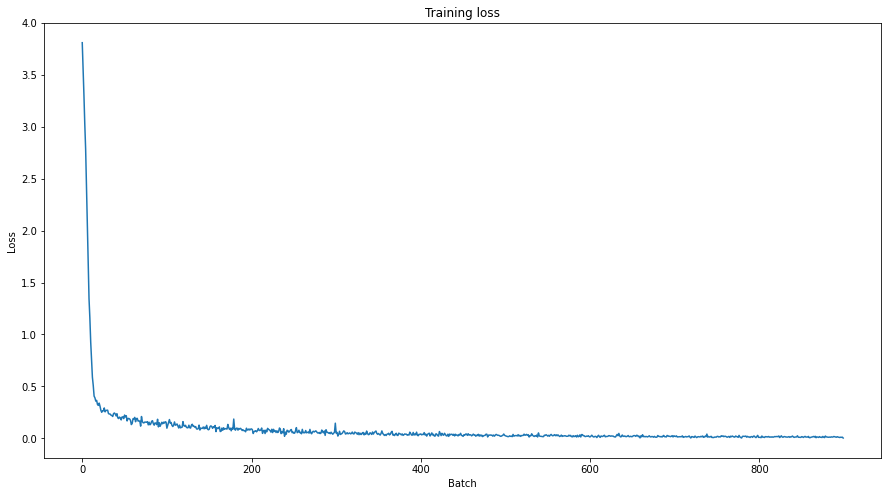

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()
